In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from problems.time_series.common import trend, seasonality, noise, windowed_dataset, plot_series, windowed_dataset_conv

tf.__version__

import typing
from tensorflow import keras

if typing.TYPE_CHECKING:
    from keras.api._v2 import keras

In [2]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

2022-02-18 21:49:45.298832: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 21:49:45.302087: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 21:49:45.302204: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 21:49:45.329238: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/100


2022-02-18 21:49:49.301411: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8302
2022-02-18 21:49:49.989438: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /usr/local/cuda/targets/x86_64-linux/lib/libcublas.so.11: undefined symbol: cublasGetSmCountTarget
2022-02-18 21:49:50.167165: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


8/8 [==============================] - 5s 25ms/step - loss: 25.7103 - mae: 26.2066 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 5ms/step - loss: 25.5530 - mae: 26.0491 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 5ms/step - loss: 25.2949 - mae: 25.7910 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 5ms/step - loss: 24.9958 - mae: 25.4913 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 5ms/step - loss: 24.6578 - mae: 25.1535 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 5ms/step - loss: 24.2954 - mae: 24.7914 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 23.8826 - mae: 24.3783 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 8ms/step - loss: 23.5079 - mae: 24.0029 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 5ms/step - loss: 23.0945 - mae: 23.5903 - lr: 2.5119e-08
Epoch 10/100

(1e-08, 0.0001, 0.0, 30.0)

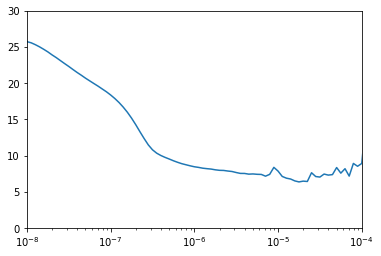

In [3]:
train_set = windowed_dataset_conv(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [4]:
dataset = windowed_dataset_conv(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=500)

Epoch 1/500
31/31 [==============================] - 3s 5ms/step - loss: 23.5745 - mae: 24.0706
Epoch 2/500
31/31 [==============================] - 0s 6ms/step - loss: 9.0258 - mae: 9.5129
Epoch 3/500
31/31 [==============================] - 0s 5ms/step - loss: 7.2255 - mae: 7.7087
Epoch 4/500
31/31 [==============================] - 0s 6ms/step - loss: 6.9983 - mae: 7.4822
Epoch 5/500
31/31 [==============================] - 0s 6ms/step - loss: 6.5628 - mae: 7.0440
Epoch 6/500
31/31 [==============================] - 0s 6ms/step - loss: 6.7803 - mae: 7.2639
Epoch 7/500
31/31 [==============================] - 0s 6ms/step - loss: 6.7980 - mae: 7.2807
Epoch 8/500
31/31 [==============================] - 0s 5ms/step - loss: 6.4905 - mae: 6.9730
Epoch 9/500
31/31 [==============================] - 0s 5ms/step - loss: 6.5388 - mae: 7.0202
Epoch 10/500
31/31 [==============================] - 0s 5ms/step - loss: 6.2850 - mae: 6.7654
Epoch 11/500
31/31 [==============================] - 0s 

8.067597


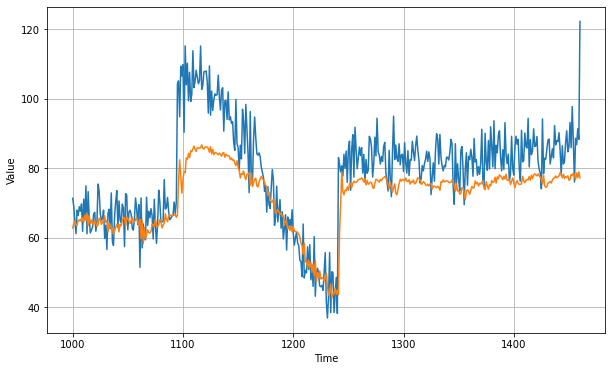

In [7]:
def model_forecast(model, series, window_size):
    ds = tf.expand_dims(series, axis=-1)  # !!!!!!!!
    ds = tf.data.Dataset.from_tensor_slices(ds)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast


rnn_forecast = model_forecast(model, series, window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

print(tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy())

<Figure size 432x288 with 0 Axes>

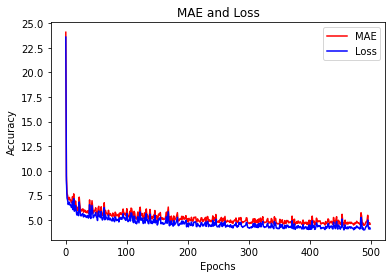

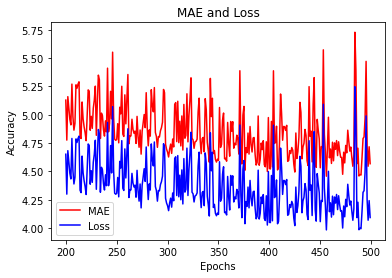

<Figure size 432x288 with 0 Axes>

In [8]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(loss))  # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()